## **LOADING DATA**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from datetime import datetime as dt
from calendar import month_abbr
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,r2_score
import optuna
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv(r"C:\Users\AD\Desktop\Data projects\python\Decision-making-system\Data\FORECASTING BUSINESS PERFORMANCE.csv")

In [ ]:
df.head()

,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,31/07/2013,78773,12,"$19,648.44","$12,309.75"
1,781,12/03/2014,90501,16,"$20,351.52","$13,497.13"
2,2090,29/11/2013,44460,26,"$111,367.62","$91,488.50"
3,1116,29/08/2018,30122,12,"$36,280.44","$21,967.81"
4,993,27/04/2013,75789,14,"$55,557.18","$48,645.87"


In [ ]:
df.shape

(976243, 6)

## **PROCESS DATA**

In [ ]:
df_model = df.copy()

In [ ]:
df_model.isnull().sum()
df_model.dropna(inplace=True)

In [ ]:
df_model.columns = df_model.columns.str.strip()
df_model

,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,31/07/2013,78773,12,"$19,648.44","$12,309.75"
1,781,12/03/2014,90501,16,"$20,351.52","$13,497.13"
2,2090,29/11/2013,44460,26,"$111,367.62","$91,488.50"
3,1116,29/08/2018,30122,12,"$36,280.44","$21,967.81"
4,993,27/04/2013,75789,14,"$55,557.18","$48,645.87"
...,...,...,...,...,...,...
976238,2213,12/08/2013,15135,1,"$1,070.37",$749.79
976239,2213,04/12/2011,80120,1,"$1,070.37",$749.79
976240,2213,29/05/2011,30028,1,"$1,070.37",$749.79
976241,2213,01/04/2014,65279,1,"$1,070.37",$749.79


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 976202 entries, 0 to 976242
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductID  976202 non-null  int64 
 1   Date       976202 non-null  object
 2   Zip        976202 non-null  int64 
 3   Units      976202 non-null  int64 
 4   Revenue    976202 non-null  object
 5   COGS       976202 non-null  object
dtypes: int64(3), object(3)
memory usage: 52.1+ MB


In [ ]:
df_model['Revenue'] = df_model['Revenue'].str.replace('[\$,]', '', regex=True).astype(float)
df_model['COGS'] = df_model['COGS'].str.replace('[\$,]', '', regex=True).astype(float)

print(df_model.dtypes)

ProductID      int64
Date          object
Zip            int64
Units          int64
Revenue      float64
COGS         float64
dtype: object


In [ ]:
df_model

,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,31/07/2013,78773,12,19648.44,12309.75
1,781,12/03/2014,90501,16,20351.52,13497.13
2,2090,29/11/2013,44460,26,111367.62,91488.50
3,1116,29/08/2018,30122,12,36280.44,21967.81
4,993,27/04/2013,75789,14,55557.18,48645.87
...,...,...,...,...,...,...
976238,2213,12/08/2013,15135,1,1070.37,749.79
976239,2213,04/12/2011,80120,1,1070.37,749.79
976240,2213,29/05/2011,30028,1,1070.37,749.79
976241,2213,01/04/2014,65279,1,1070.37,749.79


In [ ]:
df_model[df_model['Revenue'] < 0]


,ProductID,Date,Zip,Units,Revenue,COGS


In [ ]:
df_model['Profit'] = df_model['Revenue'] - df_model['COGS']
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model.drop(columns=['COGS','Revenue','ProductID','Zip'],inplace=True)

In [ ]:
df_model

,Date,Units,Profit
0,2013-07-31,12,7338.69
1,2014-03-12,16,6854.39
2,2013-11-29,26,19879.12
3,2018-08-29,12,14312.63
4,2013-04-27,14,6911.31
...,...,...,...
976238,2013-08-12,1,320.58
976239,2011-12-04,1,320.58
976240,2011-05-29,1,320.58
976241,2014-04-01,1,320.58


In [ ]:
df_daily = df_model.groupby('Date').agg({'Profit': 'sum', 'Units': 'sum'}).reset_index()

print(df_daily)


           Date     Profit  Units
0    2010-07-04  425028.13    252
1    2010-07-05  313405.57    208
2    2010-07-06   65161.55     33
3    2010-07-07  205218.83    181
4    2010-07-08  169001.59    121
...         ...        ...    ...
4248 2022-06-27  181805.24    215
4249 2022-06-28  260856.41    259
4250 2022-06-29  293958.71    278
4251 2022-06-30   94720.05     67
4252 2022-07-01  668482.99    705

[4253 rows x 3 columns]


In [ ]:
print('Starting date:',df_daily['Date'].min())
print('Ending date:',df_daily['Date'].max())

Starting date: 2010-07-04 00:00:00
Ending date: 2022-07-01 00:00:00


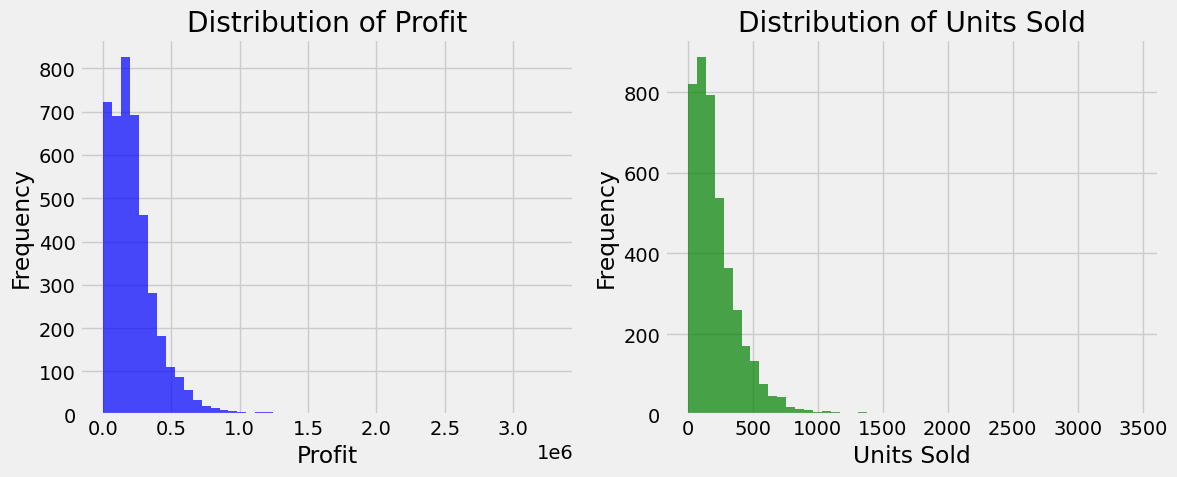

In [ ]:

df_daily = df_daily.sort_values(by='Date')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_daily['Profit'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Distribution of Profit')

plt.subplot(1, 2, 2)
plt.hist(df_daily['Units'], bins=50, color='green', alpha=0.7)
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.title('Distribution of Units Sold')

plt.tight_layout()
plt.show()




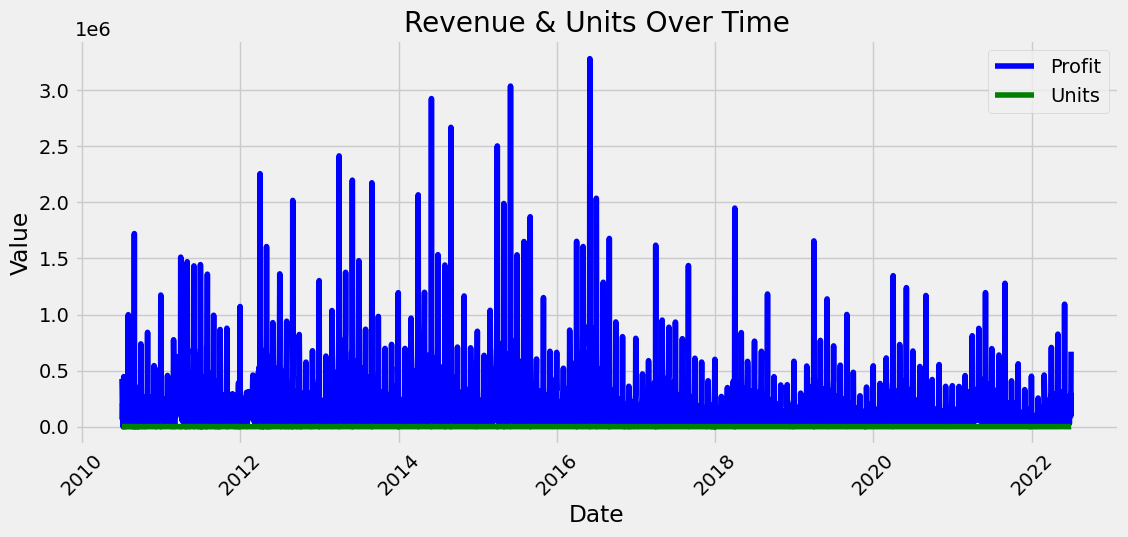

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(df_daily['Date'], df_daily['Profit'], label='Profit', color='blue')
plt.plot(df_daily['Date'], df_daily['Units'], label='Units', color='green')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Revenue & Units Over Time')
plt.legend()
plt.xticks(rotation=45)

plt.show()

In [ ]:
loss_profit_rows = df_daily[df_daily['Profit']<= 0]

if not loss_profit_rows.empty:
    print(f"Có {len(loss_profit_rows)} dòng có Profit = 0:")
    print(loss_profit_rows[['Date', 'Units','Profit']])
else:
    print("Không có dòng nào có Profit <= 0.")


Có 19 dòng có Profit = 0:
           Date  Units   Profit
5    2010-07-09      2  -251.60
45   2010-08-20      1  -145.24
55   2010-08-31      1  -108.18
69   2010-09-14      1  -318.75
76   2010-09-21      1  -100.30
329  2011-06-23      1  -148.01
343  2011-07-08      1   -75.56
423  2011-09-28      1  -109.53
456  2011-11-02      1  -100.77
490  2011-12-08      1  -466.21
503  2011-12-22      1 -1200.62
606  2012-04-12      1 -1070.58
1215 2013-12-31      3   -81.16
2234 2016-11-08      1   -14.35
2252 2016-11-26      1  -193.48
2625 2017-12-13      2  -102.78
2637 2017-12-25      9  -932.22
3321 2019-11-24      2  -890.99
4068 2021-12-25      1   -34.11


In [ ]:
def handle_outliers_iqr(df, columns):
    for column in columns:
        print(f"Cleaning column: {column}")
        print(f"Existing Min, Max Values: {df[column].agg([min, max])}")
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [ ]:
df_cleaned = handle_outliers_iqr(df_daily,['Profit','Units'])
print(df_cleaned.shape)

Cleaning column: Profit
Existing Min, Max Values: min      -1200.62
max    3281361.19
Name: Profit, dtype: float64
Cleaning column: Units
Existing Min, Max Values: min       1
max    1084
Name: Units, dtype: int64
(3968, 3)


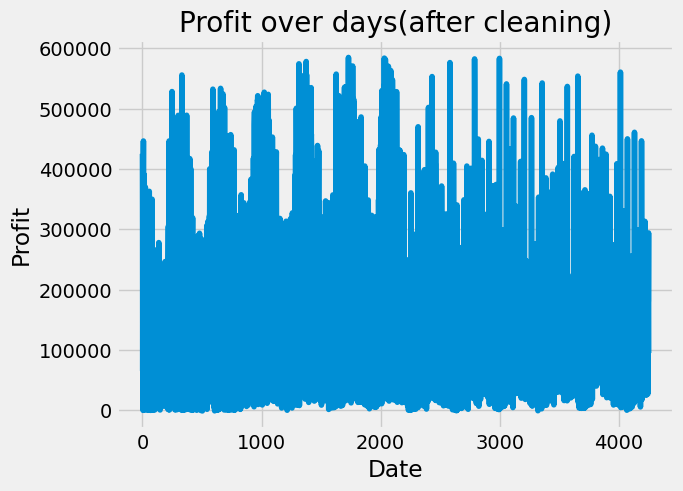

In [ ]:
df_cleaned['Profit'].plot()
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Profit over days(after cleaning)')
plt.show()

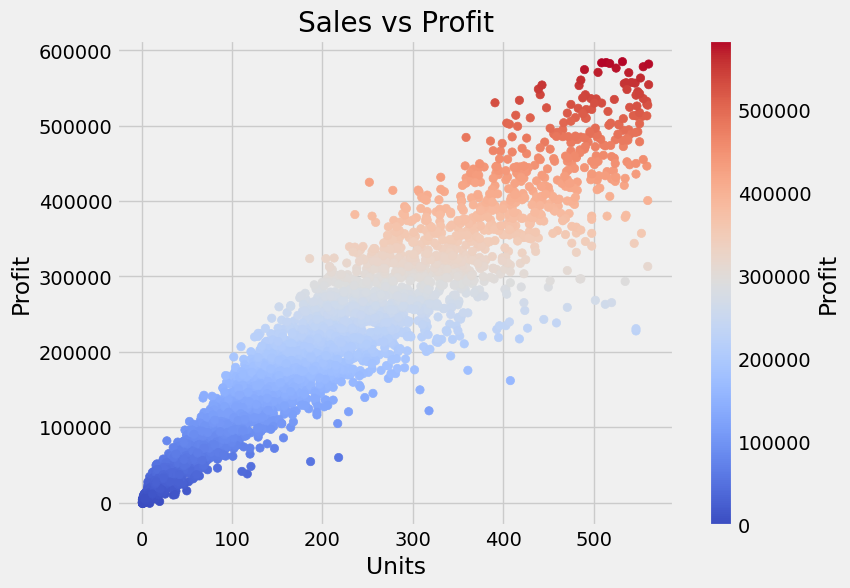

In [ ]:

plt.figure(figsize=(8, 6))
scatter_plot = plt.scatter(df_cleaned['Units'], df_cleaned['Profit'], c=df_cleaned['Profit'], cmap='coolwarm')

plt.colorbar(label='Profit')
plt.title('Sales vs Profit')
plt.xlabel('Units')
plt.ylabel('Profit')

plt.show()


In [ ]:
df_cleaned

,Date,Profit,Units
0,2010-07-04,425028.13,252
1,2010-07-05,313405.57,208
2,2010-07-06,65161.55,33
3,2010-07-07,205218.83,181
4,2010-07-08,169001.59,121
...,...,...,...
4247,2022-06-26,176602.06,215
4248,2022-06-27,181805.24,215
4249,2022-06-28,260856.41,259
4250,2022-06-29,293958.71,278


In [ ]:
df_cleaned.to_csv("test_data.csv")

In [ ]:
df_cleaned.set_index("Date", inplace=True)


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3968 entries, 2010-07-04 to 2022-06-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Profit  3968 non-null   float64
 1   Units   3968 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 93.0 KB


## **Feature Engineering**



In [ ]:
def time_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_features = time_features(df_cleaned)


In [ ]:
df_features

,Profit,Units,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2010-07-04,425028.13,252,6,3,7,2010,185,4,26
2010-07-05,313405.57,208,0,3,7,2010,186,5,27
2010-07-06,65161.55,33,1,3,7,2010,187,6,27
2010-07-07,205218.83,181,2,3,7,2010,188,7,27
2010-07-08,169001.59,121,3,3,7,2010,189,8,27
...,...,...,...,...,...,...,...,...,...
2022-06-26,176602.06,215,6,2,6,2022,177,26,25
2022-06-27,181805.24,215,0,2,6,2022,178,27,26
2022-06-28,260856.41,259,1,2,6,2022,179,28,26


In [ ]:
def add_lags(df):
    target_map = df['Profit'].to_dict()
    # Short-term lags
    df['lag_1week'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_2weeks'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_1month'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    # Medium-term lags
    df['lag_quarter'] = (df.index - pd.Timedelta('91 days')).map(target_map)
    df['lag_halfyear'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    # Yearly lags (maintaining weekday alignment)
    df['lag_1year'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2years'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3years'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    # Same month previous years (handles varying month lengths)
    df['lag_1year_exact'] = df.index.map(lambda x:
        target_map.get(x - pd.DateOffset(years=1), None))
    df['lag_2years_exact'] = df.index.map(lambda x:
        target_map.get(x - pd.DateOffset(years=2), None))
    return df

In [ ]:
df_features_lags = add_lags(df_features)


In [ ]:
df_features_lags

,Profit,Units,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1week,lag_2weeks,lag_1month,lag_quarter,lag_halfyear,lag_1year,lag_2years,lag_3years,lag_1year_exact,lag_2years_exact
Date,,,,,,,,,,,,,,,,,,,
2010-07-04,425028.13,252,6,3,7,2010,185,4,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-05,313405.57,208,0,3,7,2010,186,5,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,65161.55,33,1,3,7,2010,187,6,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-07,205218.83,181,2,3,7,2010,188,7,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-08,169001.59,121,3,3,7,2010,189,8,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,176602.06,215,6,2,6,2022,177,26,25,196907.06,175559.84,27204.77,254690.13,127717.37,217295.27,253270.12,412506.65,390221.71,237660.49
2022-06-27,181805.24,215,0,2,6,2022,178,27,26,205358.05,185086.10,55996.34,180779.31,119694.33,248584.16,304105.61,NaN,217295.27,256272.33
2022-06-28,260856.41,259,1,2,6,2022,179,28,26,185718.00,212128.77,294074.00,194586.07,106828.35,424454.44,408890.32,NaN,248584.16,253270.12


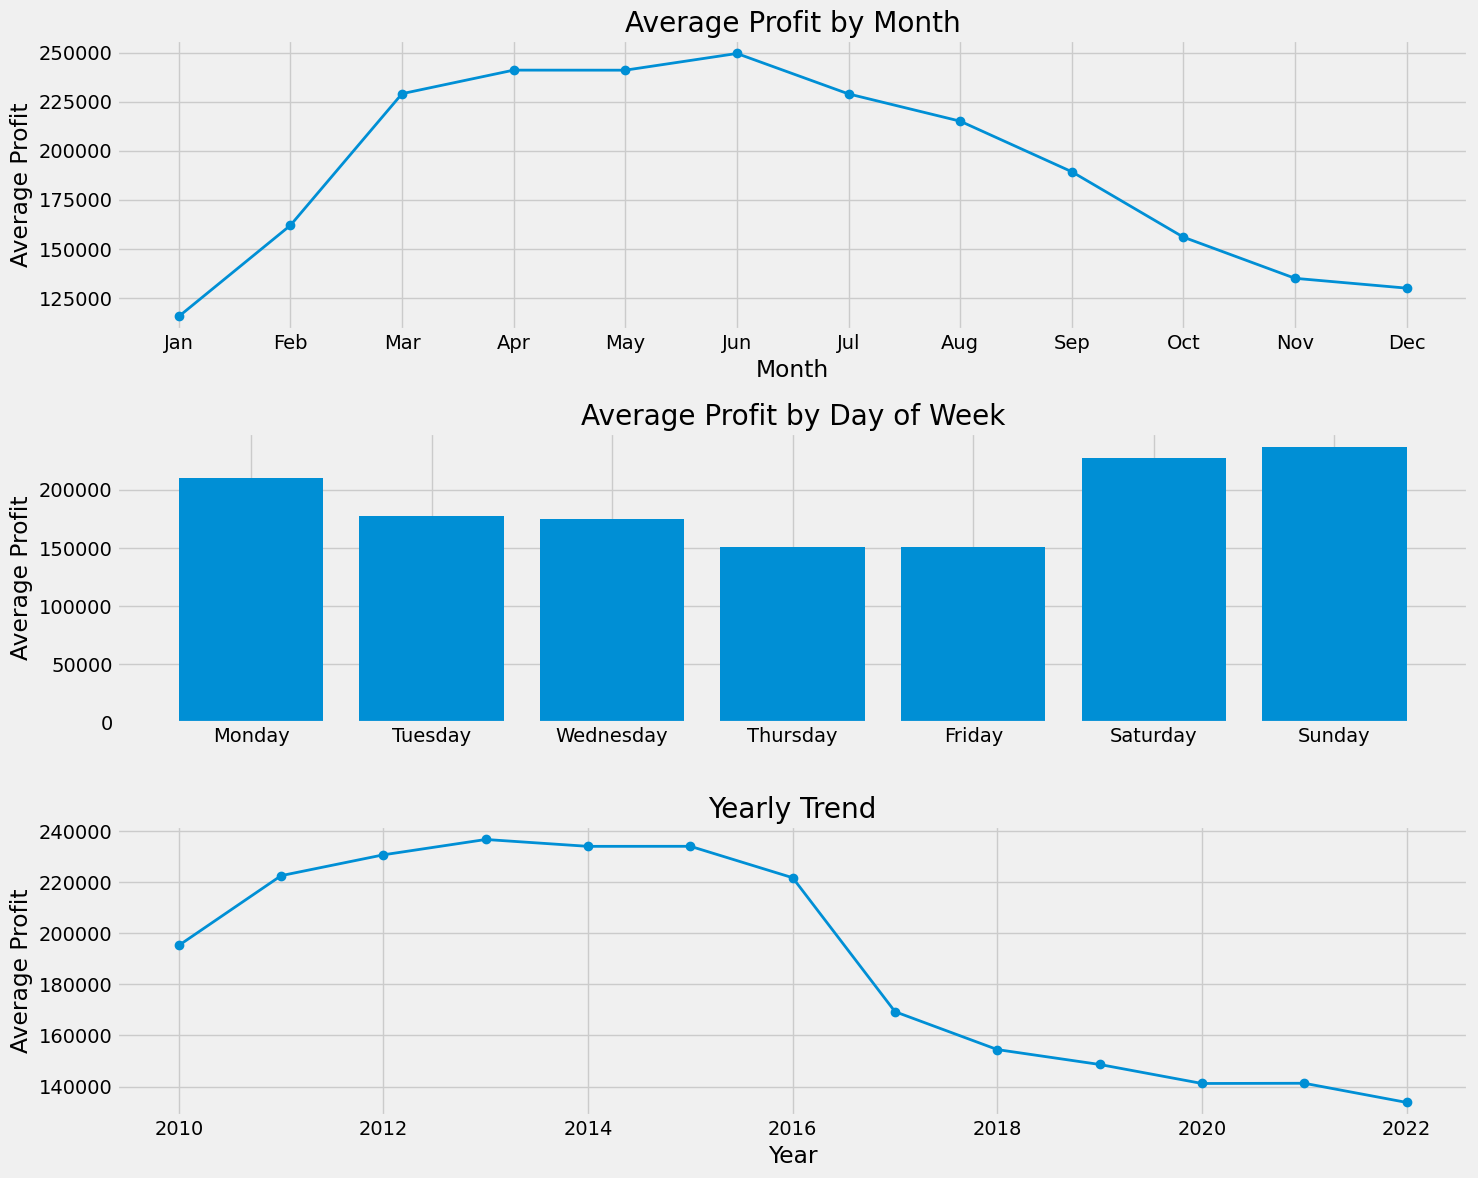

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
monthly_avg = df_features_lags.groupby('month')['Profit'].mean()
ax[0].plot(range(1, 13), monthly_avg.values, marker='o', linewidth=2)
ax[0].set_xticks(range(1, 13))
ax[0].set_xticklabels([month_abbr[i] for i in range(1, 13)])
ax[0].set_title('Average Profit by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Average Profit')
dow_avg = df_features_lags.groupby('dayofweek')['Profit'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax[1].bar(days, dow_avg.values)
ax[1].set_xticks(range(len(days)))
ax[1].set_title('Average Profit by Day of Week')
ax[1].set_ylabel('Average Profit')
yearly_avg = df_features_lags.groupby('year')['Profit'].mean()
ax[2].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2)
ax[2].set_title('Yearly Trend')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Average Profit')
plt.tight_layout()
plt.show()

## **FEATURES SELECTION**

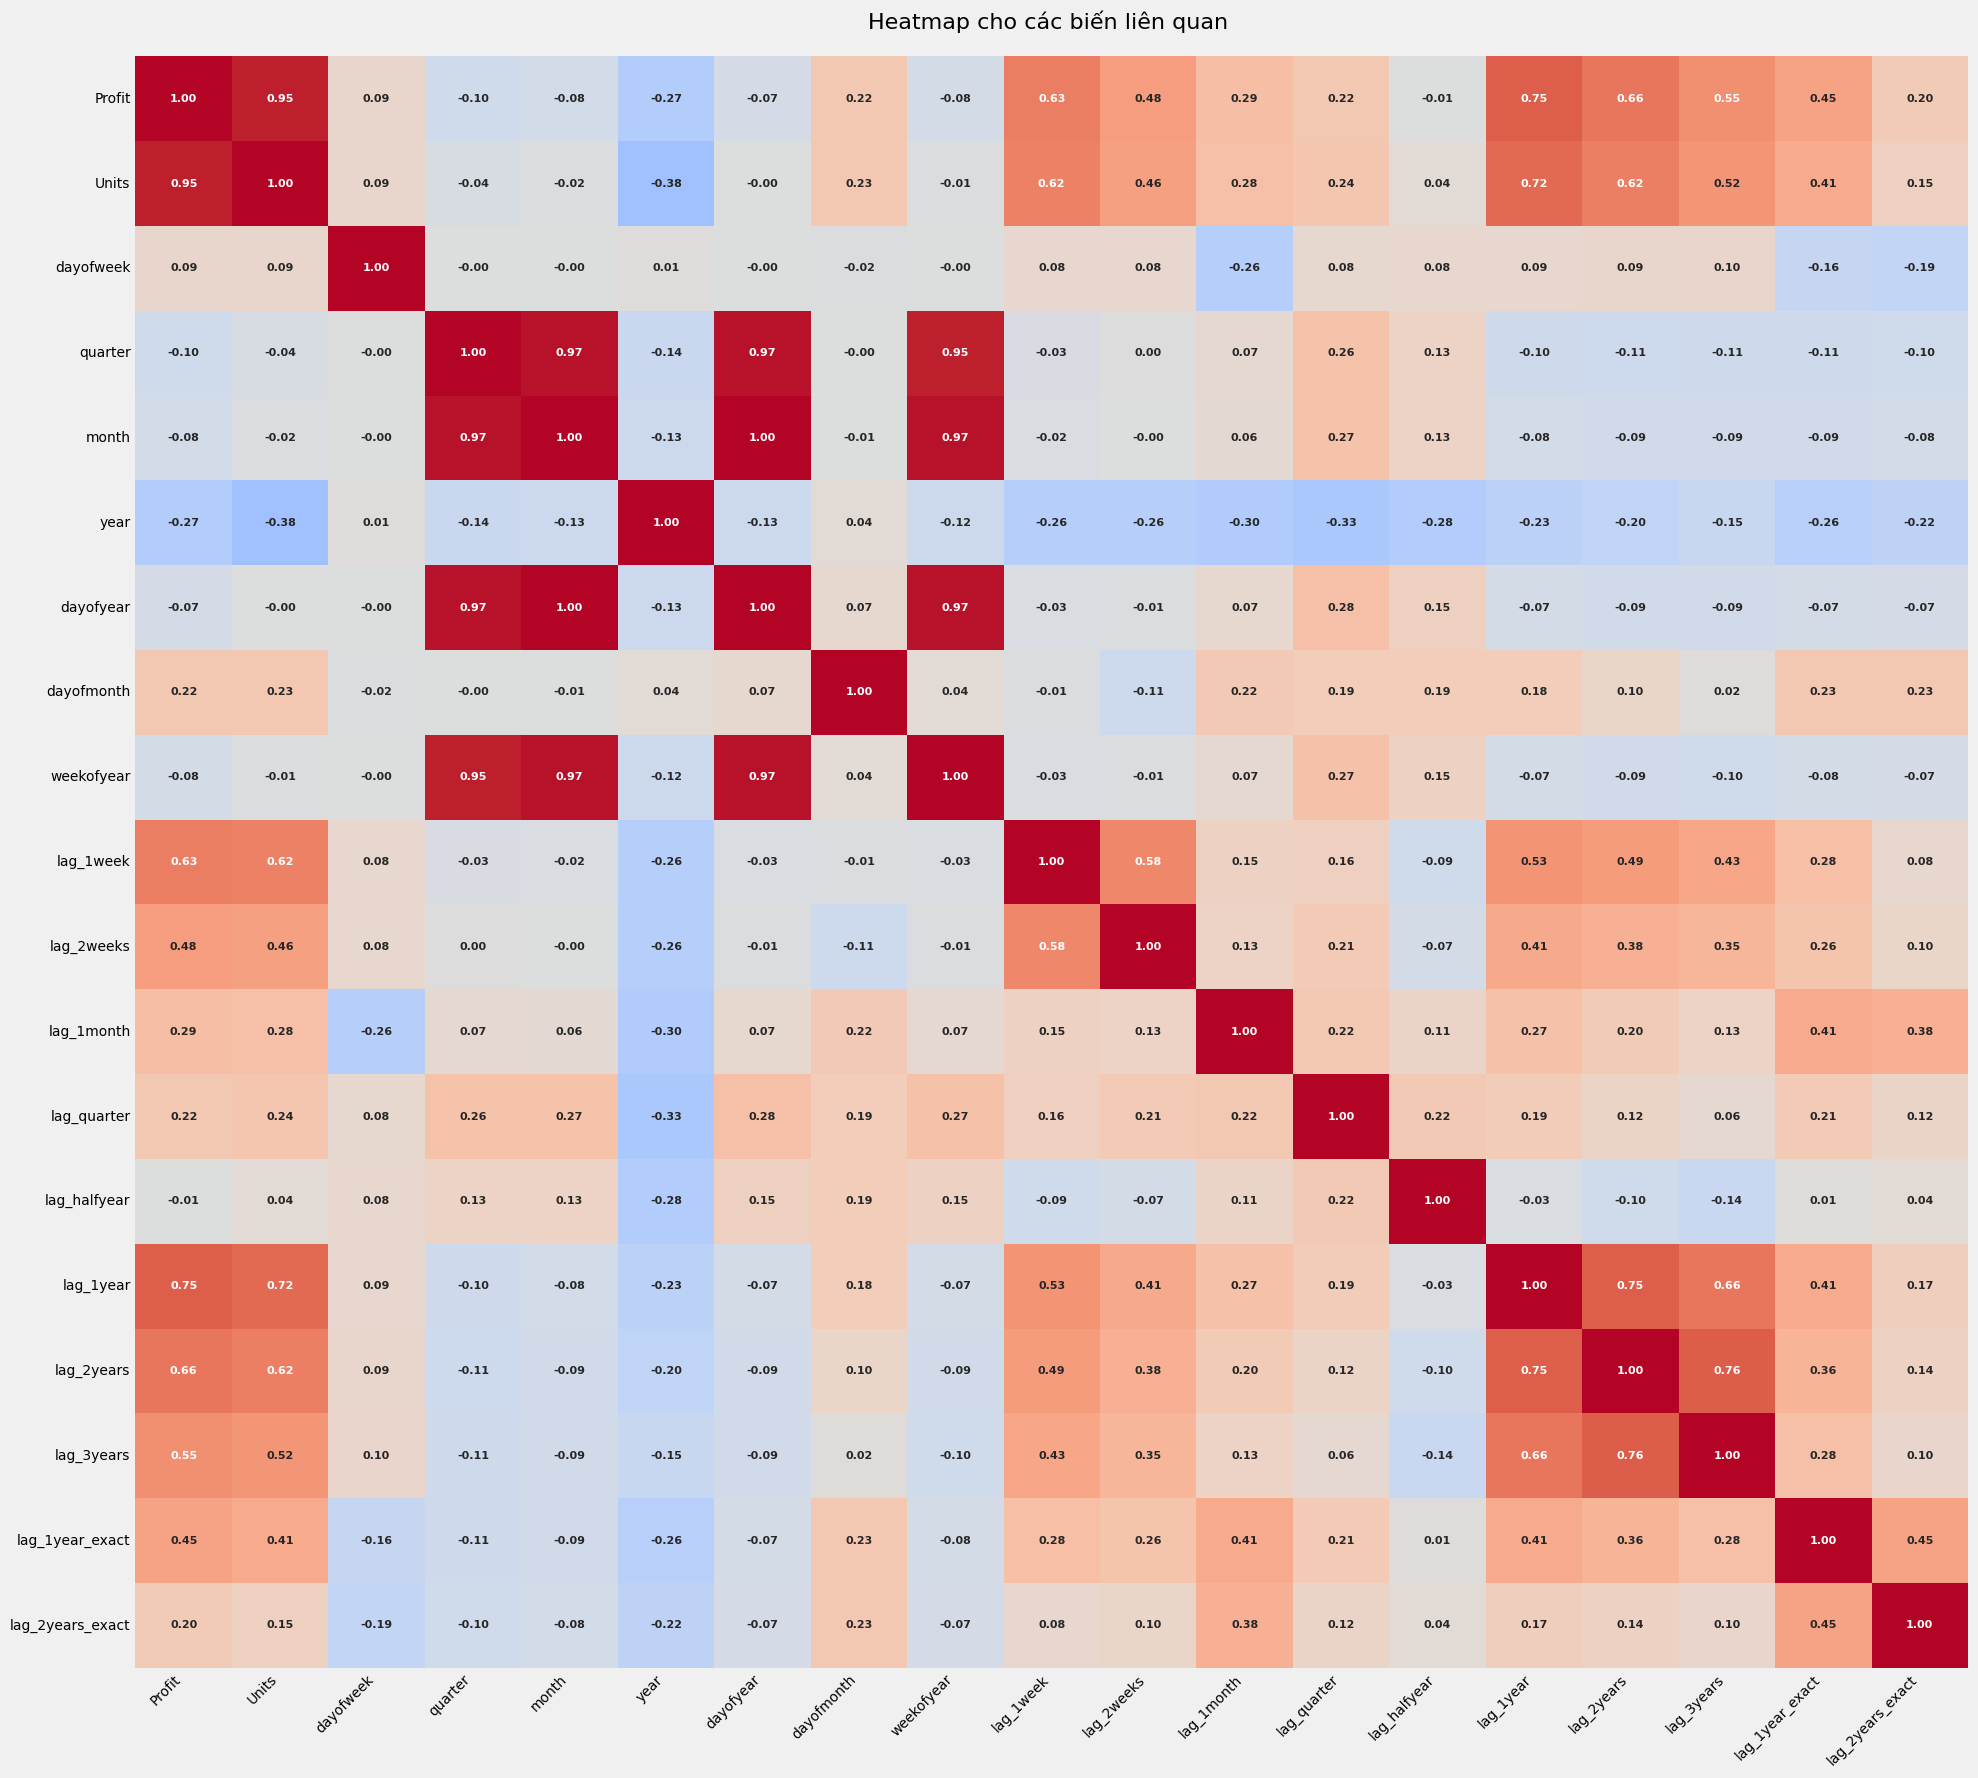

In [ ]:
corr = df_features_lags.corr()

fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f',
            cmap='coolwarm', annot_kws={'fontsize': 8, 'fontweight': 'bold'}, cbar=False)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

plt.title('Heatmap cho các biến liên quan ', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
corr_quality = corr['Profit']
corr_quality = corr_quality.abs().sort_values(ascending=False)
print('Correlation of Profit":')
print(corr_quality)

Correlation of Profit":
Profit              1.000000
Units               0.947210
lag_1year           0.752095
lag_2years          0.656938
lag_1week           0.632220
lag_3years          0.552958
lag_2weeks          0.483827
lag_1year_exact     0.451404
lag_1month          0.293493
year                0.274933
dayofmonth          0.222232
lag_quarter         0.220996
lag_2years_exact    0.199741
quarter             0.097999
dayofweek           0.086026
month               0.082839
weekofyear          0.075399
dayofyear           0.066720
lag_halfyear        0.006818
Name: Profit, dtype: float64


In [ ]:
def corr_features(df, threshold: float):
    corr_pair = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold :
                corr_pair.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))
    return corr_pair

In [ ]:
correlated_features = corr_features(df_features_lags, 0.8)

In [ ]:
correlated_features

[('Units', 'Profit', 0.9472099348940206),
 ('month', 'quarter', 0.9718972205587294),
 ('dayofyear', 'quarter', 0.9694202659953007),
 ('dayofyear', 'month', 0.9969155076648057),
 ('weekofyear', 'quarter', 0.9485681266184326),
 ('weekofyear', 'month', 0.9722383054061183),
 ('weekofyear', 'dayofyear', 0.973347315070583)]

In [ ]:
drop_features = []
for i ,j, k in correlated_features:
    drop_features.append(i)
drop_features = list(set(drop_features))
drop_features

['weekofyear', 'Units', 'month', 'dayofyear']

In [ ]:
df_model = df_features_lags.drop(columns=['Units',
 'month',
 'weekofyear',
 'dayofyear'], axis=1)


In [ ]:
df_model

,Profit,dayofweek,quarter,year,dayofmonth,lag_1week,lag_2weeks,lag_1month,lag_quarter,lag_halfyear,lag_1year,lag_2years,lag_3years,lag_1year_exact,lag_2years_exact
Date,,,,,,,,,,,,,,,
2010-07-04,425028.13,6,3,2010,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-05,313405.57,0,3,2010,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,65161.55,1,3,2010,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-07,205218.83,2,3,2010,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-08,169001.59,3,3,2010,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,176602.06,6,2,2022,26,196907.06,175559.84,27204.77,254690.13,127717.37,217295.27,253270.12,412506.65,390221.71,237660.49
2022-06-27,181805.24,0,2,2022,27,205358.05,185086.10,55996.34,180779.31,119694.33,248584.16,304105.61,NaN,217295.27,256272.33
2022-06-28,260856.41,1,2,2022,28,185718.00,212128.77,294074.00,194586.07,106828.35,424454.44,408890.32,NaN,248584.16,253270.12


## **BUILD TRIALS MODELS**

In [ ]:
feature = df_model.drop(['Profit'], axis=1).columns.to_list()
feature

['dayofweek',
 'quarter',
 'year',
 'dayofmonth',
 'lag_1week',
 'lag_2weeks',
 'lag_1month',
 'lag_quarter',
 'lag_halfyear',
 'lag_1year',
 'lag_2years',
 'lag_3years',
 'lag_1year_exact',
 'lag_2years_exact']

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_model['Profit'].values[:] = scaler.fit_transform(df_model['Profit'].values.reshape(-1, 1)).flatten()


In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=int(0.2 * len(df_features_lags)), gap=24)
df_model = df_model.sort_index()

In [ ]:
fold = 0
preds = []
scores = []
accs = []

for train_idx, val_idx in tscv.split(df_model):
    train = df_model.iloc[train_idx]
    test = df_model.iloc[val_idx]
    X_train = train[feature]
    y_train = train['Profit']
    X_test = test[feature]
    y_test = test['Profit']
    reg = xgb.XGBRegressor(n_estimators=1000,
                            learning_rate=0.01,
                            booster='gbtree',
                            max_depth=5,
                            objectives = 'reg:squarederror',
                            early_stopping_rounds=50
                            )
    reg.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
    pred = reg.predict(X_test)
    preds.append(pred)
    score = np.sqrt(mean_squared_error(y_test, pred))
    acc = r2_score(y_test, pred)
    accs.append(acc)
    scores.append(score)



[0]	validation_0-rmse:0.22548
[1]	validation_0-rmse:0.22406
[2]	validation_0-rmse:0.22258
[3]	validation_0-rmse:0.22119
[4]	validation_0-rmse:0.21977
[5]	validation_0-rmse:0.21837
[6]	validation_0-rmse:0.21699
[7]	validation_0-rmse:0.21563
[8]	validation_0-rmse:0.21437
[9]	validation_0-rmse:0.21305
[10]	validation_0-rmse:0.21177
[11]	validation_0-rmse:0.21049
[12]	validation_0-rmse:0.20926
[13]	validation_0-rmse:0.20803
[14]	validation_0-rmse:0.20685
[15]	validation_0-rmse:0.20569
[16]	validation_0-rmse:0.20454
[17]	validation_0-rmse:0.20342
[18]	validation_0-rmse:0.20230
[19]	validation_0-rmse:0.20116
[20]	validation_0-rmse:0.20005
[21]	validation_0-rmse:0.19895
[22]	validation_0-rmse:0.19792
[23]	validation_0-rmse:0.19693
[24]	validation_0-rmse:0.19587
[25]	validation_0-rmse:0.19481
[26]	validation_0-rmse:0.19374
[27]	validation_0-rmse:0.19269
[28]	validation_0-rmse:0.19166
[29]	validation_0-rmse:0.19081
[30]	validation_0-rmse:0.18988
[31]	validation_0-rmse:0.18889
[32]	validation_0-

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(accs)

Score across folds 0.1050
Fold scores:[0.13893320618098376, 0.09000567536954629, 0.08591849657701649]
[0.601030561667359, 0.7317713900311561, 0.7002751138192368]


## **Optimization**

In [ ]:
def trial_model(trial, X_train, y_train, X_val, y_val):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.05),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }

    model = xgb.XGBRegressor(**param, objective='reg:squarederror')
    model.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             verbose=False)

    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

In [ ]:
def train_evaluate_model(df_model, feature_cols, target_col='Profit', n_splits=3):
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        test_size=int(0.2 * len(df_model)),
        gap=24
    )
    results = {
        'fold_scores': [],
        'feature_importance': pd.DataFrame(),
        'best_parmas': [],
        'metrics': {
            'rmse': [],
            'mape': [],
            'r2': []
        }
    }
    for fold, (train_idx, val_idx) in enumerate(tscv.split(df_model)):
        print(f"\nTraining fold {fold + 1}/{n_splits}")
        train = df_model.iloc[train_idx]
        val = df_model.iloc[val_idx]
        X_train = train[feature_cols]
        y_train = train[target_col]
        X_val = val[feature_cols]
        y_val = val[target_col]

        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: trial_model(trial, X_train, y_train, X_val, y_val),
                    n_trials=20)
        best_params = study.best_params
        best_params['objective'] = 'reg:squarederror'
        results['best_parmas'].append(best_params)
        model = xgb.XGBRegressor(**best_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        mape = mean_absolute_percentage_error(y_val, val_pred) * 100
        r2 = r2_score(y_val, val_pred)
        results['metrics']['rmse'].append(rmse)
        results['metrics']['mape'].append(mape)
        results['metrics']['r2'].append(r2)
        fold_importance = pd.DataFrame({
            'feature': feature_cols,
            f'importance_fold_{fold}': model.feature_importances_
        })
        results['feature_importance'] = pd.concat([
            results['feature_importance'],
            fold_importance
        ], axis=1)

        print(f"Fold {fold + 1} RMSE: {rmse:.2f}")
        print(f"Fold {fold + 1} MAPE: {mape:.2f}%")
        print(f"Fold {fold + 1} R2: {r2:.3f}")
    return results

In [ ]:
results = train_evaluate_model(
    df_model=df_model,
    feature_cols=feature,
    target_col='Profit'
)

[I 2025-02-21 15:53:17,983] A new study created in memory with name: no-name-c50e3a80-f48c-4384-b24b-bd7c921b52bd



Training fold 1/3


[I 2025-02-21 15:53:20,657] Trial 0 finished with value: 0.14196194630639908 and parameters: {'n_estimators': 1802, 'max_depth': 5, 'learning_rate': 0.0038814928385545373, 'subsample': 0.9897773463992527, 'colsample_bytree': 0.8724574673407635, 'min_child_weight': 1, 'reg_alpha': 2.1897782596739936e-07, 'reg_lambda': 0.0008055186109161149}. Best is trial 0 with value: 0.14196194630639908.
[I 2025-02-21 15:53:21,000] Trial 1 finished with value: 0.14539668951879048 and parameters: {'n_estimators': 578, 'max_depth': 3, 'learning_rate': 0.035474065901453015, 'subsample': 0.9640845776942688, 'colsample_bytree': 0.7943347103315516, 'min_child_weight': 5, 'reg_alpha': 0.0006000998270300105, 'reg_lambda': 0.12009672817317689}. Best is trial 0 with value: 0.14196194630639908.
[I 2025-02-21 15:53:24,103] Trial 2 finished with value: 0.14363048632678949 and parameters: {'n_estimators': 2641, 'max_depth': 5, 'learning_rate': 0.007772757896367981, 'subsample': 0.7647110095778684, 'colsample_bytree

Fold 1 RMSE: 0.13
Fold 1 MAPE: 234.23%
Fold 1 R2: 0.627

Training fold 2/3


[I 2025-02-21 15:55:50,875] Trial 0 finished with value: 0.09204314896114568 and parameters: {'n_estimators': 1631, 'max_depth': 7, 'learning_rate': 0.0018441646404949634, 'subsample': 0.6094089922181191, 'colsample_bytree': 0.9584532152925432, 'min_child_weight': 6, 'reg_alpha': 0.0602893977646258, 'reg_lambda': 1.3842834754665933e-05}. Best is trial 0 with value: 0.09204314896114568.
[I 2025-02-21 15:55:52,101] Trial 1 finished with value: 0.13552290869506126 and parameters: {'n_estimators': 799, 'max_depth': 4, 'learning_rate': 0.001059875706928463, 'subsample': 0.7531617254248475, 'colsample_bytree': 0.6338329814816274, 'min_child_weight': 2, 'reg_alpha': 0.0005419470196902929, 'reg_lambda': 0.00011362589468230885}. Best is trial 0 with value: 0.09204314896114568.
[I 2025-02-21 15:55:53,985] Trial 2 finished with value: 0.09045450935754624 and parameters: {'n_estimators': 535, 'max_depth': 5, 'learning_rate': 0.03573338340659608, 'subsample': 0.63921342574668, 'colsample_bytree': 0

Fold 2 RMSE: 0.09
Fold 2 MAPE: 98.24%
Fold 2 R2: 0.740

Training fold 3/3


[I 2025-02-21 15:57:26,624] Trial 0 finished with value: 0.09181198423014415 and parameters: {'n_estimators': 2063, 'max_depth': 3, 'learning_rate': 0.04657665264212955, 'subsample': 0.9995761386020758, 'colsample_bytree': 0.9027201323915547, 'min_child_weight': 3, 'reg_alpha': 9.872782347768071e-08, 'reg_lambda': 1.0653136024947047e-07}. Best is trial 0 with value: 0.09181198423014415.
[I 2025-02-21 15:57:31,187] Trial 1 finished with value: 0.08628931967717389 and parameters: {'n_estimators': 2156, 'max_depth': 7, 'learning_rate': 0.016827628161767427, 'subsample': 0.7193826751101371, 'colsample_bytree': 0.6852869535317532, 'min_child_weight': 4, 'reg_alpha': 0.0003070563558708451, 'reg_lambda': 0.0012636056546519788}. Best is trial 1 with value: 0.08628931967717389.
[I 2025-02-21 15:57:33,614] Trial 2 finished with value: 0.08938521055820359 and parameters: {'n_estimators': 1545, 'max_depth': 5, 'learning_rate': 0.0015962785310358733, 'subsample': 0.6190711319015387, 'colsample_bytr

Fold 3 RMSE: 0.09
Fold 3 MAPE: 66.66%
Fold 3 R2: 0.705


## **==> We use fold 2 based on R2_score**


In [ ]:
best_params = results['best_parmas'][1]
best_params

{'n_estimators': 1989,
 'max_depth': 6,
 'learning_rate': 0.0037980999206249657,
 'subsample': 0.8828135286837675,
 'colsample_bytree': 0.9140222895721412,
 'min_child_weight': 6,
 'reg_alpha': 1.8214632628704548e-07,
 'reg_lambda': 1.552941662928041e-07,
 'objective': 'reg:squarederror'}

In [ ]:
features_importance = results['feature_importance']
features_importance

,feature,importance_fold_0,feature,importance_fold_1,feature,importance_fold_2
0,dayofweek,0.010128,dayofweek,0.028643,dayofweek,0.032934
1,quarter,0.026088,quarter,0.074460,quarter,0.062919
2,year,0.015231,year,0.053274,year,0.056719
3,dayofmonth,0.060651,dayofmonth,0.082922,dayofmonth,0.079628
4,lag_1week,0.219023,lag_1week,0.238599,lag_1week,0.189088
5,lag_2weeks,0.044586,lag_2weeks,0.053110,lag_2weeks,0.053080
6,lag_1month,0.031330,lag_1month,0.026766,lag_1month,0.031514
7,lag_quarter,0.030558,lag_quarter,0.020578,lag_quarter,0.024636
8,lag_halfyear,0.036845,lag_halfyear,0.026652,lag_halfyear,0.026222
9,lag_1year,0.348487,lag_1year,0.269975,lag_1year,0.276021


In [ ]:
best_model = xgb.XGBRegressor(
   n_estimators= 1989,
 max_depth=6,
 learning_rate=0.0037980999206249657,
 subsample= 0.8828135286837675,
 colsample_bytree= 0.9140222895721412,
 min_child_weight= 6,
 reg_alpha= 1.8214632628704548e-07,
 reg_lambda= 1.552941662928041e-07,
 objective='reg:squarederror'
)

In [ ]:
import joblib as jb

jb.dump(best_model, 'xgb_model.pkl')
jb.dump(scaler, 'xgb_scaler.pkl')

['xgb_scaler.pkl']

## **Test with new data**

In [ ]:
df_test = pd.read_csv(r"")
scaler = MinMaxScaler(feature_range=(0, 1))
#(Ở đây có thể test vói bất kì dataset nào , có thể tự lấy dataset theo 1 id sản phẩm bất kì trong file excelexcel)

In [ ]:
df_test

,Unnamed: 0,Date,Profit,Units
0,0,2010-07-04,425028.13,252
1,1,2010-07-05,313405.57,208
2,2,2010-07-06,65161.55,33
3,3,2010-07-07,205218.83,181
4,4,2010-07-08,169001.59,121
...,...,...,...,...
3963,4247,2022-06-26,176602.06,215
3964,4248,2022-06-27,181805.24,215
3965,4249,2022-06-28,260856.41,259
3966,4250,2022-06-29,293958.71,278


In [ ]:
df_test.columns.to_list()


['Unnamed: 0', 'Date', 'Profit', 'Units']

In [ ]:
df_test  = df_test.drop(columns='Unnamed: 0')

In [ ]:
df_test['Date'] = pd.to_datetime(df_test['Date'])


In [ ]:
df_test.set_index("Date", inplace=True)


In [ ]:
df_test.shape

(3968, 2)

In [ ]:
df_test

,Profit,Units
Date,,
2010-07-04,425028.13,252
2010-07-05,313405.57,208
2010-07-06,65161.55,33
2010-07-07,205218.83,181
2010-07-08,169001.59,121
...,...,...
2022-06-26,176602.06,215
2022-06-27,181805.24,215
2022-06-28,260856.41,259


In [ ]:
def time_features_modified(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    target_map = df['Profit'].to_dict()
    # Short-term lags
    df['lag_1week'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_2weeks'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_1month'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    # Medium-term lags
    df['lag_quarter'] = (df.index - pd.Timedelta('91 days')).map(target_map)
    df['lag_halfyear'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    # Yearly lags (maintaining weekday alignment)
    df['lag_1year'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2years'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3years'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    # Same month previous years (handles varying month lengths)
    df['lag_1year_exact'] = df.index.map(lambda x:
        target_map.get(x - pd.DateOffset(years=1), None))
    df['lag_2years_exact'] = df.index.map(lambda x:
        target_map.get(x - pd.DateOffset(years=2), None))
    return df

In [ ]:
df_features_test = time_features_modified(df_test)


In [ ]:
df_features_test

,Profit,Units,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1week,lag_2weeks,lag_1month,lag_quarter,lag_halfyear,lag_1year,lag_2years,lag_3years,lag_1year_exact,lag_2years_exact
Date,,,,,,,,,,,,,,,,,,,
2010-07-04,425028.13,252,6,3,7,2010,185,4,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-05,313405.57,208,0,3,7,2010,186,5,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,65161.55,33,1,3,7,2010,187,6,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-07,205218.83,181,2,3,7,2010,188,7,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-08,169001.59,121,3,3,7,2010,189,8,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,176602.06,215,6,2,6,2022,177,26,25,196907.06,175559.84,27204.77,254690.13,127717.37,217295.27,253270.12,412506.65,390221.71,237660.49
2022-06-27,181805.24,215,0,2,6,2022,178,27,26,205358.05,185086.10,55996.34,180779.31,119694.33,248584.16,304105.61,NaN,217295.27,256272.33
2022-06-28,260856.41,259,1,2,6,2022,179,28,26,185718.00,212128.77,294074.00,194586.07,106828.35,424454.44,408890.32,NaN,248584.16,253270.12


In [ ]:
df_model_test = df_features_test.copy()

In [ ]:
testing_features = df_model_test.drop(columns=['Profit','Units', 'month', 'weekofyear', 'dayofyear'])

testing_target = df_model_test['Profit']


In [ ]:
testing_target

Date
2010-07-04    425028.13
2010-07-05    313405.57
2010-07-06     65161.55
2010-07-07    205218.83
2010-07-08    169001.59
                ...    
2022-06-26    176602.06
2022-06-27    181805.24
2022-06-28    260856.41
2022-06-29    293958.71
2022-06-30     94720.05
Name: Profit, Length: 3968, dtype: float64

In [ ]:
best_model.fit(testing_features, testing_target)
test_pred = best_model.predict(testing_features)

In [ ]:
test_rmse = np.sqrt(mean_squared_error(testing_target, test_pred))
test_mape = mean_absolute_percentage_error(testing_target, test_pred) * 100
test_r2 = r2_score(testing_target, test_pred)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R2: {test_r2:.3f}")

Test RMSE: 32594.53
Test MAPE: 738.34%
Test R2: 0.933


In [ ]:
df_result = df_features_test[['Profit']]

In [ ]:
df_result

,Profit
Date,
2010-07-04,425028.13
2010-07-05,313405.57
2010-07-06,65161.55
2010-07-07,205218.83
2010-07-08,169001.59
...,...
2022-06-26,176602.06
2022-06-27,181805.24
2022-06-28,260856.41


In [ ]:
df_result['prediction'] = test_pred
df_result

,Profit,prediction
Date,,
2010-07-04,425028.13,332693.218750
2010-07-05,313405.57,221337.062500
2010-07-06,65161.55,177081.343750
2010-07-07,205218.83,173278.984375
2010-07-08,169001.59,164064.640625
...,...,...
2022-06-26,176602.06,199498.875000
2022-06-27,181805.24,201879.500000
2022-06-28,260856.41,254823.453125


In [ ]:
df_monthly = df_result.resample('M').mean()


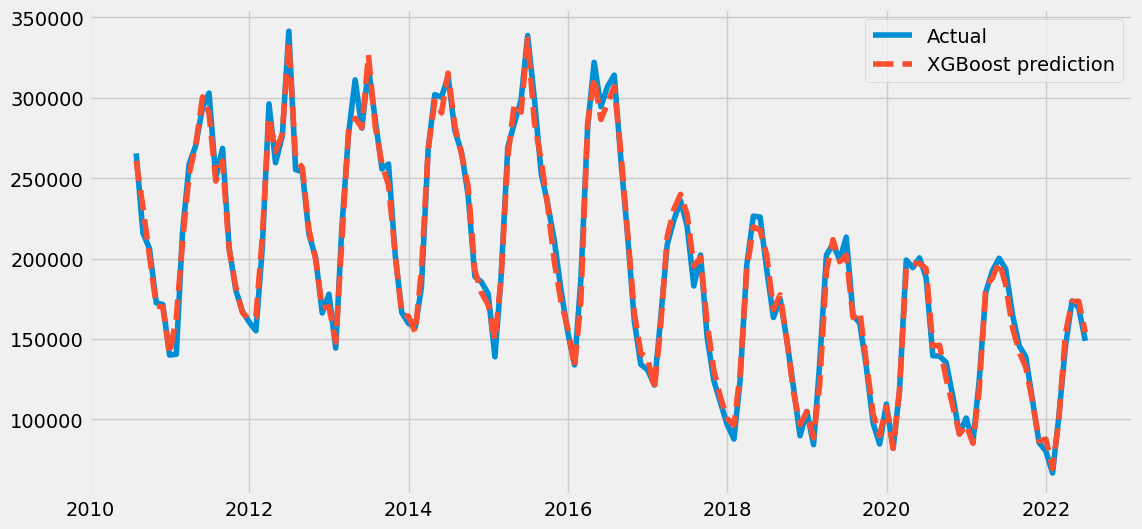

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Profit'], label='Actual')
plt.plot(df_monthly.index, df_monthly['prediction'], label='XGBoost prediction', linestyle='dashed')
plt.legend()
plt.show()

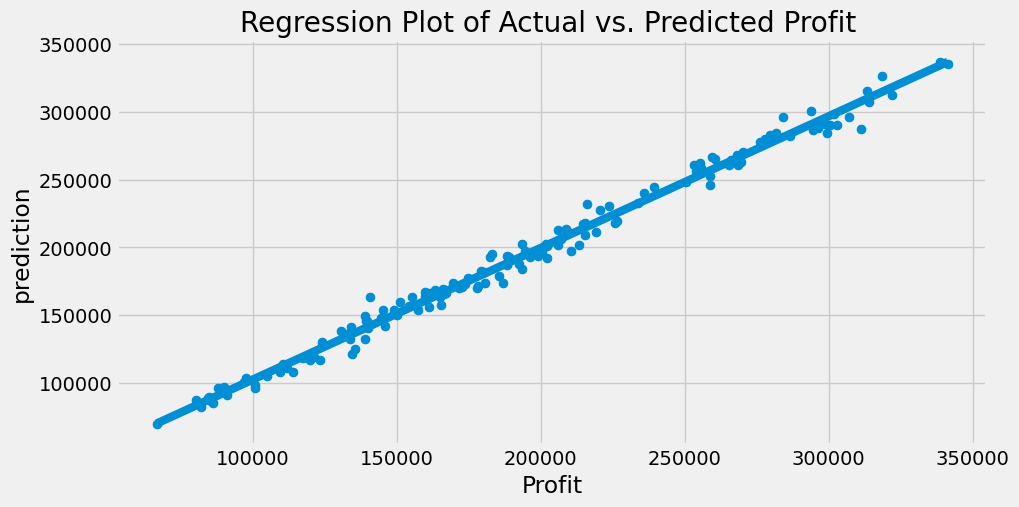

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df_monthly['Profit'], df_monthly['prediction'])
plt.xlabel("Profit")
plt.ylabel("prediction")
sns.regplot(x="Profit", y="prediction", data=df_monthly)
plt.title("Regression Plot of Actual vs. Predicted Profit ")
plt.show()

## **Predictiction for the next 12 months**

In [ ]:
df_features_test

,Profit,Units,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1week,lag_2weeks,lag_1month,lag_quarter,lag_halfyear,lag_1year,lag_2years,lag_3years,lag_1year_exact,lag_2years_exact
Date,,,,,,,,,,,,,,,,,,,
2010-07-04,425028.13,252,6,3,7,2010,185,4,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-05,313405.57,208,0,3,7,2010,186,5,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,65161.55,33,1,3,7,2010,187,6,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-07,205218.83,181,2,3,7,2010,188,7,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-08,169001.59,121,3,3,7,2010,189,8,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,176602.06,215,6,2,6,2022,177,26,25,196907.06,175559.84,27204.77,254690.13,127717.37,217295.27,253270.12,412506.65,390221.71,237660.49
2022-06-27,181805.24,215,0,2,6,2022,178,27,26,205358.05,185086.10,55996.34,180779.31,119694.33,248584.16,304105.61,NaN,217295.27,256272.33
2022-06-28,260856.41,259,1,2,6,2022,179,28,26,185718.00,212128.77,294074.00,194586.07,106828.35,424454.44,408890.32,NaN,248584.16,253270.12


In [ ]:

def visualize_report(df):
    fig_report, ax = plt.subplots(3, 1, figsize=(15, 12))
    monthly_avg = df.groupby('month')['Profit'].mean()
    ax[0].plot(range(1, 13), monthly_avg.values, marker='o', linewidth=2)
    ax[0].set_xticks(range(1, 13))
    ax[0].set_xticklabels([month_abbr[i] for i in range(1, 13)])
    ax[0].set_title('Average Profit by Month')
    ax[0].set_xlabel('Month')
    ax[0].set_ylabel('Average Profit')
    dow_avg = df.groupby('dayofweek')['Profit'].mean()
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ax[1].bar(days, dow_avg.values)
    ax[1].set_xticks(range(len(days)))
    ax[1].set_title('Average Profit by Day of Week')
    ax[1].set_ylabel('Average Profit')
    yearly_avg = df.groupby('year')['Profit'].mean()
    ax[2].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2)
    ax[2].set_title('Yearly Trend')
    ax[2].set_xlabel('Year')
    ax[2].set_ylabel('Average Profit')
    plt.tight_layout()
    plt.show(fig_report)

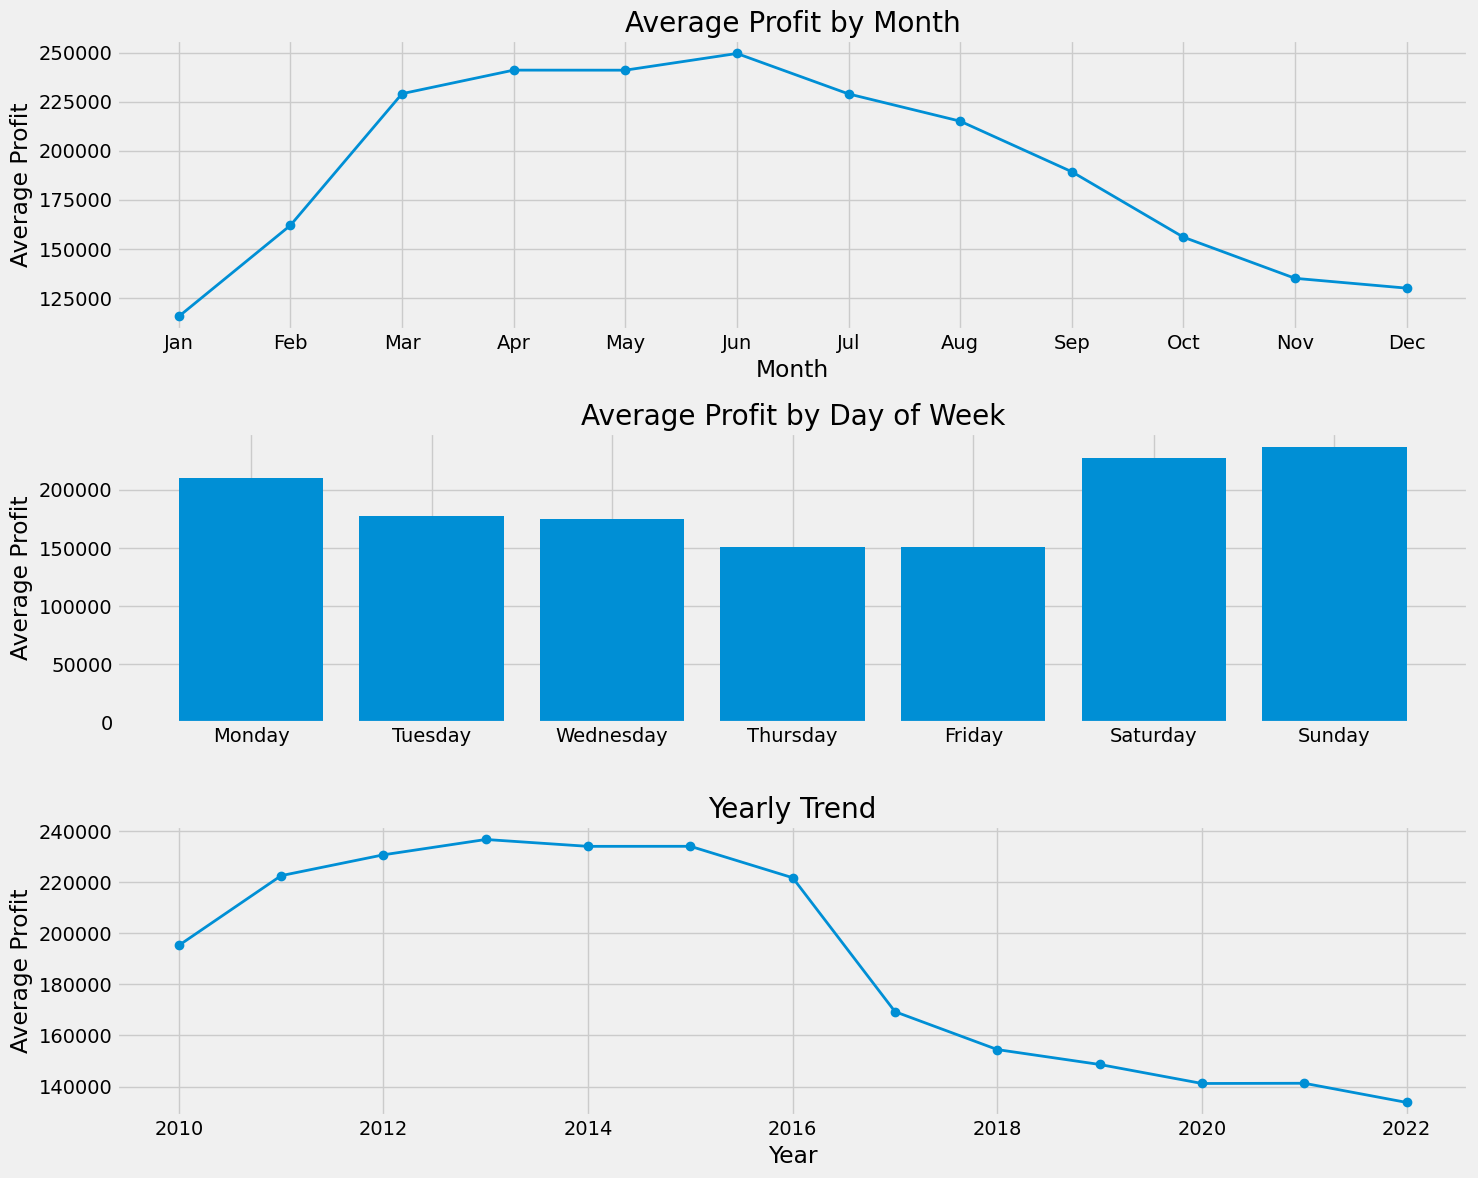

In [ ]:
visualize_report(df_features_test)

In [ ]:

def forecasting(df, future: int):
    future = max(1, int(future))
    df_future = df.copy()
    feature_cols = [col for col in df.columns if col not in ['Profit','Units', 'month', 'weekofyear', 'dayofyear']]
    X_train = df[feature_cols]
    y_train = df['Profit']
    best_model.fit(X_train, y_train)
    last_record = X_train.iloc[-1:].values
    forecast = []
    for _ in range(future):
        prediction = best_model.predict(last_record).reshape(-1, 1)
        prediction_value = float(prediction[0][0])
        last_record = np.hstack([last_record[:, 1:], np.array([[prediction_value]])])
        forecast.append(prediction_value)
    future_dates = pd.date_range(
        start=df_future.index.max() + pd.Timedelta(days=1),
        periods=future,
        freq='D'
    )
    future_predictions = pd.DataFrame({'Future': forecast}, index=future_dates)
    df_month = df.resample('M')['Profit'].mean().to_frame()
    df_future_month = future_predictions.resample('M').mean()
    df_future_result = pd.concat([df_month, df_future_month], axis=1)
    df_future_result['Profit'] = df_future_result['Profit'].fillna(df_future_result['Future'])
    df_final = df_future_result[['Profit']].dropna()
    return df_final, df_month.index.max(), df_final.index.max()

In [ ]:
df_final,last_records_before_future,last_records_after_future = forecasting(df_features_test,365)
df_final

,Profit
2010-07-31,265410.775000
2010-08-31,215984.281923
2010-09-30,206159.002500
2010-10-31,172505.991724
2010-11-30,171459.276538
...,...
2023-02-28,37721.204520
2023-03-31,35920.936933
2023-04-30,36708.062044
2023-05-31,38796.136404


In [ ]:
last_records_before_future,last_records_after_future

(Timestamp('2022-06-30 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [ ]:
def visualize_forecast(df, split_date=None):
    fig_forecast=plt.figure(figsize=(12, 6))
    if not split_date:
        split_date = df.dropna().index.max()
    else:
        split_date = pd.to_datetime(split_date)
    plt.plot(df.loc[:split_date].index, df.loc[:split_date]["Profit"], label="Actual Profit", color="blue")
    plt.plot(df.loc[split_date:].index, df.loc[split_date:]["Profit"],linestyle='dashed', label="Predicted Profit", color="red")
    plt.legend()
    plt.tight_layout()
    plt.show(fig_forecast)

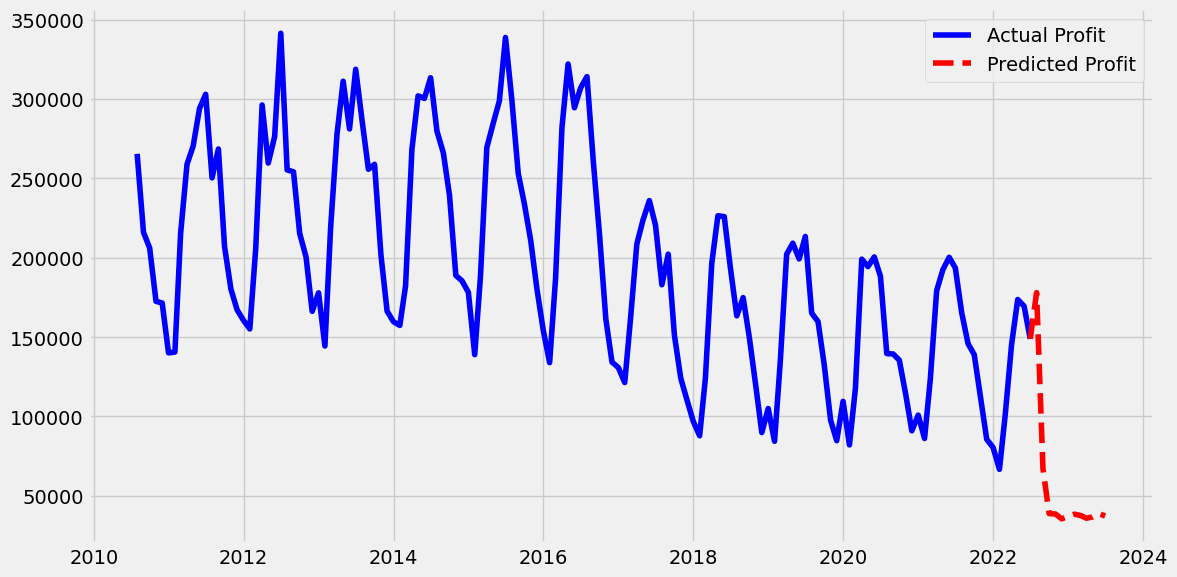

In [ ]:
visualize_forecast(df_final,last_records_before_future)